In [1]:
#!pip install -e ../Maccabee > /dev/null

In [2]:
# %load_ext autoreload
# %autoreload 2

In [232]:
from maccabee.data_analysis.data_metrics import AXES_AND_METRIC_NAMES
from maccabee.constants import Constants
import maccabee.data_sources as data_sources
from maccabee.parameters import build_default_parameters

from maccabee.data_generation import DataGeneratingProcess, SampledDataGeneratingProcess, data_generating_method
from maccabee.data_generation.utils import evaluate_expression, CompiledExpression
# benchmarks
from maccabee.benchmarking import benchmark_model_using_concrete_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp_grid

# genmatch
from maccabee.examples.genmatch import GenmatchDataGeneratingProcess, build_genmatch_datasource, GENMATCH_SPECS
from maccabee.examples.genmatch import LogisticPropensityMatchingCausalModel
from maccabee.examples.genmatch import GENMATCH_BINARY_COVAR_INDECES

In [268]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sympy.polys.polytools import poly
from collections import defaultdict
import scipy.stats as st

In [5]:
BASE_GENMATCH_DGP_PARAMS = {
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "TREATMENT_EFFECT_HETEROGENEITY": 0,
  "ACTUAL_CONFOUNDER_ALIGNMENT": 0,
  "TARGET_PROPENSITY_SCORE": 0.5,
#   "MIN_PROPENSITY_SCORE": 0.05,
#   "MAX_PROPENSITY_SCORE": 0.95,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}

A_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
A_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}
A_param_overrides["ACTUAL_CONFOUNDER_ALIGNMENT"] = 0.285
  
C_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
C_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.3,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}
C_param_overrides["ACTUAL_CONFOUNDER_ALIGNMENT"] = -1

G_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
G_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.75,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.22,
    "INTERACTION_THREE_WAY": 0,
}
G_param_overrides["ACTUAL_CONFOUNDER_ALIGNMENT"] = 0.15

GENMATCH_PARAM_OVERRIDES = {
    "A": A_param_overrides,
    "C": C_param_overrides,
    "G": G_param_overrides,
}

In [6]:
# Define axes and metrics to analyze
DATA_METRICS_SPEC = {
    Constants.AxisNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)",
        "Lin r2(X_true, Y)"
    ],
    Constants.AxisNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)",
        "Lin r2(X_true, Treat Logit)",
        "Log r2(X_obs, T)"
    ],
    Constants.AxisNames.PERCENT_TREATED: [
        "Percent(T==1)"
    ],
    Constants.AxisNames.BALANCE: [
        "Wass dist X_true: T=1<->T=0",
    ],
    Constants.AxisNames.ALIGNMENT: [
        "Lin r2(Y, Treat Logit)",
        "Lin r2(Y0, Treat Logit)"
    ],
    Constants.AxisNames.TE_HETEROGENEITY: [
        "std(TE)/std(Y)"
    ]
}

In [7]:
N_CORES = 8
N_THREADS = 1

In [8]:
import pickle
import uuid
import datetime
import glob

RESULT_DIR = "results/genmatch/"

def persist_result(name, data):
    timestamp = str(datetime.datetime.now())[11:-7]
    file_name = name + "-" + timestamp + ".pkl"
    file_path = RESULT_DIR + file_name

    with open(file_path, "wb") as res_file:
        pickle.dump(data, res_file)

    return file_name


def read_result(base_name):
    if base_name[-3:] == "pkl":
        file_path = RESULT_DIR + base_name
    else:
        file_path_pattern = RESULT_DIR + f"{base_name}*.pkl"
        file_paths = sorted(glob.glob(file_path_pattern))
        file_path = file_paths[-1] # most recent
    
    print("Fetching", file_path)
    with open(file_path, "rb") as res_file:
        result_entry = pickle.load(res_file)
    
    return result_entry

# name = persist_result("testresult", (1, 2, 3, 4, 6))
# read_result(name)

In [9]:
COMPARISON_BENCHMARK = "G"

## Run MC Benchmarks

In [10]:
 %%time

CONCRETE_IN_ANALYSIS_MODE = True
CONCRETE_CACHED = True
CONCRETE_RESULT_BASENAME = f"concrete_{COMPARISON_BENCHMARK}"

if not CONCRETE_CACHED:
    # Concrete Genmatch Benchmark
    dgp = GenmatchDataGeneratingProcess(
        dgp_label=COMPARISON_BENCHMARK,
        n_observations=1000,
        data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE)

    concrete_result = benchmark_model_using_concrete_dgp(
            dgp=dgp,
            model_class=LogisticPropensityMatchingCausalModel,
            estimand=Constants.Model.ATT_ESTIMAND,
            num_sampling_runs_per_dgp=100,
            num_samples_from_dgp=64,
            data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE,
            data_metrics_spec=DATA_METRICS_SPEC,
            n_jobs=N_CORES,
            n_threads=N_THREADS)
    
    persist_result(CONCRETE_RESULT_BASENAME,concrete_result)
else:
    concrete_result = read_result(CONCRETE_RESULT_BASENAME)

concrete_perf_agg, concrete_perf_raw, concrete_data_agg, concrete_data_raw = \
    concrete_result


Fetching results/genmatch/concrete_G-14:16:20.pkl
CPU times: user 2.37 ms, sys: 2.25 ms, total: 4.62 ms
Wall time: 13.3 ms


In [11]:
# TRUE_TREAT_LOGIT = dgp.treatment_logit_expression

# class GenmatchEquivDataGeneratingProcess(SampledDataGeneratingProcess):
#     @data_generating_method(Constants.DGPVariables.OUTCOME_NOISE_NAME, [])
#     def _generate_outcome_noise_samples(self, input_vars):
#         return 0
    
#     @data_generating_method(Constants.DGPVariables.TREATMENT_EFFECT_NAME, [])
#     def _generate_treatment_effects(self, input_vars):
#         return -0.4
    
#     @data_generating_method(Constants.DGPVariables.PROPENSITY_SCORE_NAME,
#                             [Constants.DGPVariables.COVARIATES_NAME])
#     def _generate_true_propensity_scores(self, input_vars):
#         observed_covariate_data = input_vars[Constants.DGPVariables.COVARIATES_NAME]

#         logits = evaluate_expression(
#             TRUE_TREAT_LOGIT,
#             observed_covariate_data)

#         return 1/(1 + np.exp(-1*logits))

In [12]:
from maccabee.data_generation.utils import evaluate_expression

DGPVariables = Constants.DGPVariables

SAMPLED_DYNAMIC = True
SAMPLED_OUTCOME_BIAS = True
DGPVariables.NORMALIZE_SAMPLED_OUTCOME_FUNCTION = False
DGPVariables.NORMALIZE_SAMPLED_TREATMENT_FUNCTION = True

# Sampled Genmatch Benchmark
class GenmatchLikeSampledDataGeneratingProcess(SampledDataGeneratingProcess):
    def __init__(self, *args, **kwargs):
        compile_functions = kwargs.pop("compile_functions")
        kwargs["compile_functions"] = False
        
        super().__init__(*args, **kwargs)
        if SAMPLED_OUTCOME_BIAS:
            self.bias = -3.85
            np.append(self.outcome_covariate_transforms, self.bias)
            self.untreated_outcome_subfunction += self.bias
            self.outcome_function += self.bias
            
        if compile_functions:
            self.untreated_outcome_subfunction = \
                CompiledExpression(self.untreated_outcome_subfunction)
            self.treatment_assignment_function = \
                CompiledExpression(self.treatment_assignment_function)

    @data_generating_method(DGPVariables.OUTCOME_NOISE_NAME, [])
    def _generate_outcome_noise_samples(self, input_vars):
        return 0
    
    @data_generating_method(DGPVariables.TREATMENT_EFFECT_NAME, [])
    def _generate_treatment_effects(self, input_vars):
        return -0.4
    
    # dynamic dataset generation.
    @data_generating_method(DGPVariables.COVARIATES_NAME, [])
    def _generate_observed_covars(self, input_vars):
        if SAMPLED_DYNAMIC:
            return self.data_source.get_covar_df() 
        else:
            return self.observed_covariate_data
    
    @data_generating_method(
        DGPVariables.POTENTIAL_OUTCOME_WITHOUT_TREATMENT_NAME,
        [DGPVariables.COVARIATES_NAME],
        cache_result=(not SAMPLED_DYNAMIC))
    def _generate_outcomes_without_treatment(self, input_vars):
        observed_covariate_data = input_vars[DGPVariables.COVARIATES_NAME]
        return evaluate_expression(
            self.untreated_outcome_subfunction,
            observed_covariate_data) 

    @data_generating_method(
        DGPVariables.TREATMENT_EFFECT_NAME,
        [DGPVariables.COVARIATES_NAME],
        cache_result=(not SAMPLED_DYNAMIC))
    def _generate_treatment_effects(self, input_vars):
        observed_covariate_data = input_vars[DGPVariables.COVARIATES_NAME]
        return evaluate_expression(
            self.treatment_effect_subfunction,
            observed_covariate_data)

    @data_generating_method(
        DGPVariables.POTENTIAL_OUTCOME_WITH_TREATMENT_NAME,
        [
            DGPVariables.POTENTIAL_OUTCOME_WITHOUT_TREATMENT_NAME,
            DGPVariables.TREATMENT_EFFECT_NAME
        ],
        cache_result=(not SAMPLED_DYNAMIC))
    def _generate_outcomes_with_treatment(self, input_vars):
        outcome_without_treatment = input_vars[DGPVariables.POTENTIAL_OUTCOME_WITHOUT_TREATMENT_NAME]
        treatment_effect = input_vars[DGPVariables.TREATMENT_EFFECT_NAME]
        return outcome_without_treatment + treatment_effect

In [13]:
%%time

SAMPLED_IN_ANALYSIS_MODE = True
SAMPLED_CACHED = False
SAMPLE_COMPILE = True
SAMPLED_RESULT_BASENAME = f"sampled_{COMPARISON_BENCHMARK}"

QUICK_EVAL = {
    "num_dgp_samples": 5,
    "num_sampling_runs_per_dgp": 3,
    "num_samples_from_dgp": 24,
    "dgp_kwargs": {
        "data_analysis_mode": SAMPLED_IN_ANALYSIS_MODE,
        "compile_functions": False
    },
}

SOLID_EVAL = {
    "num_dgp_samples": 30,
    "num_sampling_runs_per_dgp": 6,
    "num_samples_from_dgp": 88,
    "dgp_kwargs": {
        "data_analysis_mode": SAMPLED_IN_ANALYSIS_MODE,
        "compile_functions": True
    },
}

param_overrides = GENMATCH_PARAM_OVERRIDES[COMPARISON_BENCHMARK]

if not SAMPLED_CACHED:
    dgp_params = build_default_parameters()
    dgp_params.set_parameters(param_overrides)

    sampled_result = \
        benchmark_model_using_sampled_dgp(
            dgp_params, build_genmatch_datasource(),
            dgp_class=GenmatchLikeSampledDataGeneratingProcess,
            model_class=LogisticPropensityMatchingCausalModel,
            estimand=Constants.Model.ATE_ESTIMAND,
            data_analysis_mode=SAMPLED_IN_ANALYSIS_MODE,
            data_metrics_spec=DATA_METRICS_SPEC,
            n_jobs=N_CORES,
            n_threads=N_THREADS,
            **SOLID_EVAL)

    persist_result(SAMPLED_RESULT_BASENAME, sampled_result)
else:
    sampled_result = read_result(SAMPLED_RESULT_BASENAME)
    
(
    sampled_perf_agg, sampled_perf_raw,
    sampled_perf_run_raw, sampled_data_agg,
    sampled_data_raw, dgps
) = sampled_result

Reducing alignment from 0.16 to 0.15
Reducing alignment from 0.208 to 0.15
Increasing alignment
Reducing alignment from 0.16 to 0.15
Reducing alignment from 0.16 to 0.15
Reducing alignment from 0.16 to 0.15
Reducing alignment from 0.208 to 0.15
Reducing alignment from 0.16 to 0.15
Reducing alignment from 0.208 to 0.15
Reducing alignment from 0.16 to 0.15
Reducing alignment from 0.208 to 0.15
Reducing alignment from 0.208 to 0.15
Reducing alignment from 0.208 to 0.15
Reducing alignment from 0.208 to 0.15
Reducing alignment from 0.16 to 0.15
Reducing alignment from 0.208 to 0.15
Reducing alignment from 0.208 to 0.15
Reducing alignment from 0.16 to 0.15
Increasing alignment
Reducing alignment from 0.208 to 0.15
Reducing alignment from 0.208 to 0.15
Increasing alignment
Reducing alignment from 0.208 to 0.15
Reducing alignment from 0.261 to 0.15
Reducing alignment from 0.261 to 0.15
Reducing alignment from 0.16 to 0.15
Reducing alignment from 0.208 to 0.15
Reducing alignment from 0.208 to 0

## Old Result Parsing

In [14]:
# import sys
# mm = list(filter(lambda x: x.startswith("multi"), sys.modules))
# print(mm)
# class A():
#     pass
# #     NEWOBJ = object()
    
#     class RebuildProxy():
#         def __init__(self, *args, **kwargs):
#             print(args, kwargs)
        
#         def __getstate__(self):
#             return {}
        
#         def __setstate__(self, state):
#             print(state)
    
#     class ListProxy():
#         def __init__(self, *args, **kwargs):
#             print(args, kwargs)
        
#         def __getstate__(self):
#             return {}
        
#         def __setstate__(self, state):
#             print(state)
    
#     class Token():
#         def __init__(self, *args, **kwargs):
#             print(args, kwargs)
        
#         def __getstate__(self):
#             return {}
        
#         def __setstate__(self, state):
#             print(state)

    
# sys.modules['multiprocessing.managers'] = A
# # for m in mm:
# #     print(m)
# #     del sys.modules[m]

In [15]:
# sampled_result = read_result("sampled_G-09:13:59.pkl")
# sampled_result = read_result("sampled_G-09:43:27.pkl")

    
# (
#     sampled_perf_agg, sampled_perf_raw,
#     sampled_perf_run_raw, sampled_data_agg,
#     sampled_data_raw, dgps
# ) = sampled_result

## Data Metric Comparison

In [16]:
if SAMPLED_IN_ANALYSIS_MODE and CONCRETE_IN_ANALYSIS_MODE:
    for axes, metrics in DATA_METRICS_SPEC.items():
        print(axes)
        for metric in metrics:
            print("\t", metric)

            key = f"{axes} {metric}"
            print("\t\tConcrete:", np.round(concrete_data_agg[key], 3))
            print("\t\tSampled:", np.round(sampled_data_agg[key], 3))
    
    for name, vals in sampled_data_raw.items():
        if name.startswith("TREATMENT_NONLINEARITY"):
            print(name, vals)

OUTCOME_NONLINEARITY
	 Lin r2(X_obs, Y)
		Concrete: 0.971
		Sampled: 0.96
	 Lin r2(X_true, Y)
		Concrete: 0.973
		Sampled: 0.964
TREATMENT_NONLINEARITY
	 Lin r2(X_obs, Treat Logit)
		Concrete: 0.787
		Sampled: 0.539
	 Lin r2(X_true, Treat Logit)
		Concrete: 1.0
		Sampled: 1.0
	 Log r2(X_obs, T)
		Concrete: 0.725
		Sampled: 0.631
PERCENT_TREATED
	 Percent(T==1)
		Concrete: 45.016
		Sampled: 50.027
BALANCE
	 Wass dist X_true: T=1<->T=0
		Concrete: 0.053
		Sampled: 0.043
ALIGNMENT
	 Lin r2(Y, Treat Logit)
		Concrete: 0.031
		Sampled: 0.167
	 Lin r2(Y0, Treat Logit)
		Concrete: 0.006
		Sampled: 0.172
TE_HETEROGENEITY
	 std(TE)/std(Y)
		Concrete: 0.0
		Sampled: 0.0
TREATMENT_NONLINEARITY Log r2(X_obs, T) [0.595, 0.642, 0.629, 0.656, 0.627, 0.641, 0.638, 0.572, 0.571, 0.629, 0.673, 0.628, 0.651, 0.625, 0.652, 0.635, 0.608, 0.631, 0.649, 0.651, 0.632, 0.686, 0.644, 0.59, 0.655, 0.673, 0.607, 0.601, 0.632, 0.621]
TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit) [0.269, 0.623, 0.467, 0.804, 0.

## Performance Comparison

Notes

At config A, 20-50 matches across runs. Wide distro. Should investigate the stability of the concrete distro when n=1000.

At config G, 20-50 has much lower bias in the sampled benchmark. The concrete function appears to be a worst case scenario given that very similar functions experience much lower typical bias. The distribution is right tailed and so it is possible that the concrete func chosen is just an (un)lucky sample from right tail.

I will test this by permuting the variable order in the exact same functional form.

### Concrete Performance

In [34]:
concrete_perf_agg

{'RMSE': 0.106, 'RMSE (std)': 0.007, 'AMBP': 13.034, 'AMBP (std)': 2.172}

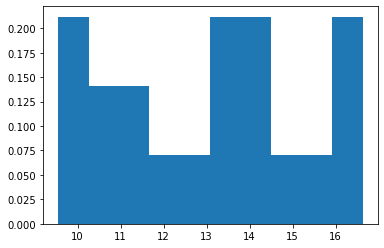

In [35]:
plt.hist(concrete_perf_raw["AMBP"], density=True)
plt.show()

### Sampled Performance

In [19]:
sampled_perf_agg

{'RMSE': 0.106, 'RMSE (std)': 0.034, 'AMBP': 11.221, 'AMBP (std)': 25.677}

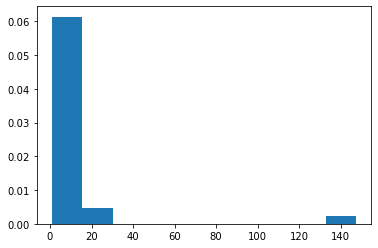

6.520896551724138


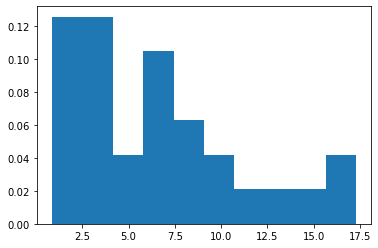

In [20]:
data = np.array(sampled_perf_raw["AMBP"])
plt.hist(data, density=True)
plt.show()

print(np.mean(data[data < 50]))
plt.hist(data[data < 50], density=True)
plt.show()

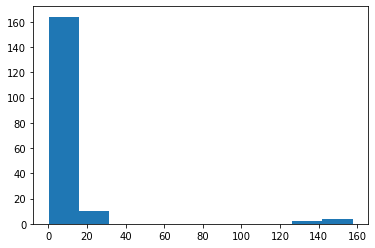

In [21]:
flat_list = [item for sublist in sampled_perf_run_raw["AMBP"] for item in sublist]
plt.hist(flat_list)
plt.show()

In [22]:
sampled_perf_run_raw["AMBP"]

[[2.640847001576897,
  0.9649069184183352,
  1.4449839622661718,
  1.5236632567784016,
  1.2526344904276572,
  3.7121303344185197],
 [3.6978148142933938,
  6.043981378420141,
  2.4298812916918964,
  0.7249432891396626,
  9.198533910471433,
  5.971102966624347],
 [11.786534302822936,
  10.521318801675497,
  9.94518094023291,
  6.344082552628063,
  9.471314581252956,
  9.150106115235236],
 [7.038472290042265,
  9.832007892393028,
  8.574622730409644,
  10.968718000587065,
  6.586444796225443,
  4.488002526707364],
 [0.8988245042032555,
  0.18277688241900827,
  1.2304886072722643,
  0.08900402000834029,
  1.0498390495037784,
  1.6547132865571332],
 [157.74649559924922,
  147.53436898915467,
  139.28102440974314,
  153.18600603461314,
  134.3091699356854,
  153.15005804122896],
 [5.258403828969045,
  1.8768287343013699,
  7.843989230058821,
  8.7400367858686,
  1.514226395007006,
  5.157641494630856],
 [5.080404934311391,
  6.4502808898760255,
  10.422382764537625,
  5.438648443362948,
  6

In [23]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

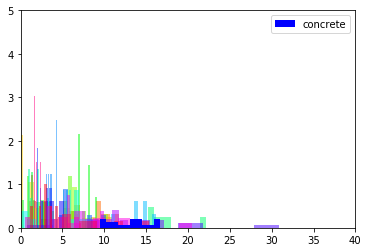

In [24]:
cmap = get_cmap(len(sampled_perf_run_raw["AMBP"]))

for i, runs in enumerate(sampled_perf_run_raw["AMBP"]):
    plt.hist(runs, density=True, alpha=0.5, color=cmap(i))
#     plt.axvline(x=np.mean(runs), alpha=0.25)
#     plt.axvline(x=np.median(runs), alpha=0.5, c=cmap(i))
    
plt.hist(concrete_perf_raw["AMBP"], density=True, color="b", label="concrete")
# plt.axvline(x=np.mean(concrete_perf_raw["AMBP"]), c="r")
# plt.axvline(x=np.median(concrete_perf_raw["AMBP"]), c="b")
plt.legend()
plt.xlim((0, 40))
plt.ylim((0, 5))
plt.show()
# 

In [25]:
metric = "TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"

In [26]:
sample_metric_vals = sampled_data_raw[metric]
concrete_metric_val = concrete_data_agg[metric]

In [27]:
concrete_metric_val

0.787

In [28]:
sorted(np.abs(sample_metric_vals - concrete_metric_val)), np.std(sample_metric_vals)

([0.017000000000000015,
  0.02100000000000002,
  0.04600000000000004,
  0.061000000000000054,
  0.09600000000000009,
  0.10299999999999998,
  0.11299999999999999,
  0.123,
  0.127,
  0.138,
  0.15399999999999991,
  0.16400000000000003,
  0.18300000000000005,
  0.19900000000000007,
  0.21400000000000008,
  0.244,
  0.252,
  0.259,
  0.28300000000000003,
  0.30200000000000005,
  0.32,
  0.321,
  0.381,
  0.47300000000000003,
  0.515,
  0.518,
  0.525,
  0.562,
  0.626,
  0.658],
 0.20772422958228912)

[False False False  True False False False False False False  True False
 False False  True False False False  True False False False False False
  True False False False False False]
13.034 7.064004217592182


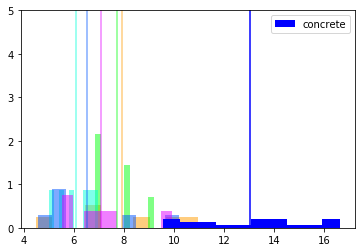

In [39]:
sample_metric_vals = sampled_data_raw[metric]
sample_metric_std = np.std(sample_metric_vals)
select_tol = 0.1#0.5*sample_metric_std
selected_runs = np.abs(sample_metric_vals - concrete_metric_val) < select_tol
print(selected_runs)

cmap = get_cmap(len(sampled_perf_run_raw["AMBP"]))

means = []
for i, runs in enumerate(sampled_perf_run_raw["AMBP"]):
    if i < len(selected_runs) and selected_runs[i] and np.mean(runs) < 60:
        means.append(np.mean(runs))
        plt.hist(runs, density=True, alpha=0.5, color=cmap(i))
        plt.axvline(x=np.mean(runs), alpha=0.5, c=cmap(i))
#         plt.axvline(x=np.median(runs), alpha=0.5, c=cmap(i))
        
print(concrete_perf_agg["AMBP"], np.mean(means))  
plt.hist(concrete_perf_raw["AMBP"], density=True, color="b", label="concrete")
plt.axvline(x=np.mean(concrete_perf_raw["AMBP"]), c="b")
# plt.axvline(x=np.median(concrete_perf_raw["AMBP"]), c="b")
# plt.xlim((0, 30))
plt.ylim((0, 5))
plt.legend()
plt.show()
# 

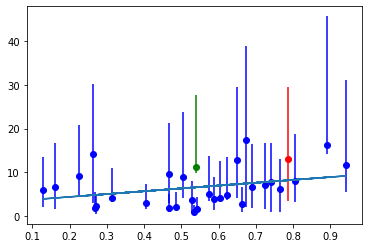

In [82]:
# Concrete
plt.scatter(concrete_data_agg[metric], concrete_perf_agg["AMBP"],
            c="r", label="concrete") 
interval_data = np.percentile(np.array(concrete_perf_raw["AMBP"]),
                              [2.5, 97.5]).reshape((2, 1))
plt.errorbar(concrete_data_agg[metric], concrete_perf_agg["AMBP"],
             interval_data, fmt='none', c="r")

# Sampled Mean
plt.scatter(sampled_data_agg[metric], sampled_perf_agg["AMBP"],
            c="g", label="concrete") 
interval_data = np.percentile(np.array(sampled_perf_raw["AMBP"])[perf_data<100],
                              [2.5, 97.5]).reshape((2, 1))
plt.errorbar(sampled_data_agg[metric], sampled_perf_agg["AMBP"],
             interval_data, fmt='none', c="g")

# DGP level scatter plot
perf_data = np.array(sampled_perf_raw["AMBP"])
sample_metric_data = np.array(sample_metric_vals)
plt.scatter(sample_metric_data[perf_data<100], perf_data[perf_data<100], c="b")

# Run level intervals for each point
interval_data = np.percentile(np.array(sampled_perf_run_raw["AMBP"]), [2.5, 97.5], axis=1)
interval_data = interval_data[:, perf_data<100]
plt.errorbar(sample_metric_data[perf_data<100], perf_data[perf_data<100],
             interval_data, fmt='none', c="b")

# regression plot
coeffs = np.polyfit(sample_metric_data[perf_data<100], perf_data[perf_data<100], 1)
plt.plot(sample_metric_data[perf_data<100], coeffs[0]*sample_metric_data[perf_data<100] + coeffs[1])

plt.show()

# For fixed forms, there is a diversity of metric values
# with different performance metrics. These correspond to the metric
# in a way we expect. Even at a single metric value there is noise which
# requires averaging.

In [233]:
sampled_dgp_transforms = map(lambda x: x[1].treatment_covariate_transforms, list(dgps))
category_data = list(map(categorize_terms, sampled_dgp_transforms))

In [255]:
categories = [
    Constants.DGPSampling.INTERACTION_TWO_WAY,
    Constants.DGPSampling.POLY_QUADRATIC,
    Constants.DGPSampling.LINEAR,
]
for category in categories:
    category_counts = list(map(lambda data: data[0][category], category_data))
    print(category, np.mean(category_counts), np.std(category_counts))

binary_data = []

for data in category_data:
    interactions = data[1][Constants.DGPSampling.INTERACTION_TWO_WAY]
    get_is_binary_statuses = lambda var_name: int(str(var_name)[1:]) in GENMATCH_BINARY_COVAR_INDECES
    
    interaction_binary_classes = [
        categorize_interaction_two_way([
            get_is_binary_statuses(interaction_var)
            for interaction_var in interaction_vars
        ])
        for interaction_vars in interactions
    ]
    
    binary_data.append(interaction_binary_classes)

binary_data = np.array(binary_data)
both_counts = np.sum(binary_data == "both", axis=1)
one_counts = np.sum(binary_data == "one", axis=1)

INTERACTION_TWO_WAY 12.0 0.0
POLY_QUAD 3.0 0.0
LINEAR 6.966666666666667 0.3144660377352202


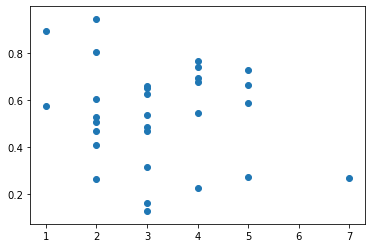

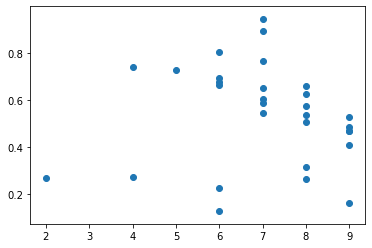

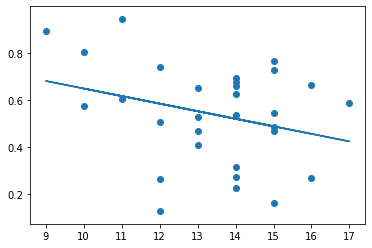

In [262]:
plt.scatter(both_counts, sample_metric_vals)
plt.show()

plt.scatter(one_counts, sample_metric_vals)
plt.show()

agg_counts = 2*both_counts + one_counts
plt.scatter(agg_counts, sample_metric_vals)

# regression plot
coeffs = np.polyfit(agg_counts, sample_metric_vals, 1)
plt.plot(agg_counts, coeffs[0]*agg_counts + coeffs[1])

plt.show()

# The choice of binary interactions matters for the metric (which we know)
# is correlated with the performance of the estimator.

## Narrative

Authors create a semi realistic data set - mix of binary and normal covariates.

The hand-select a set of functions with escalating levels of nonlinearity and non-additivity.

This analysis will show why this is a problematic strategy. Instead of tuning Maccabee to sample from specific location: sample functions which look very similar to their function in terms of expected structure.

Keep everything else constant: same data, same constant treatment effect, same lack of outcome noise, same coeff distro (by inspection) *TODO verify this distr via histogram*. *TODO: see what happens with non-dynamic datasets*.

This is a much lower variance setting than a standard maccabee sampler: normally would sample a wide class of functions with similar metrics. Here, we sample from the class of functions. Implication is that variance in this class is a subset of wider variance we would expect from the universe of possible functional forms could have selected.

The results show the following:
- We do indeed sample from universe of same structure functions. Ratio of components is identical.
- There is a wide distro over performance
- Digging into this, we see one contributing factor is a distro over the treatment assignment metric. **IE, identical structure** is producing highly varied non-linearity metrics.
- It could be that this metric is useless but we see that it is indeed strongly correlated with performance of the estimator. So the metric matters.

It appears the variance comes from different distro over binary variables in the interactions. This is logical given it is the only real difference.

**Key take-aways**

- Hand specified forms are a single sample from a (potentially wide) distribution over **realized** value of targeted distributional setting as proxied by values of metrics. And these distributional setting are correlated to performance (again, via metrics) (as is expected)

- This would be even wider if we sampled from a wider class of variables (*TODO relax the constrains by moving back to soft sampler and see what happens*)

- Even within a single metric setting, there is variance from other factors - both data set and other distributional setting values. This means that even with in a fixed target, there is a need for averaging.

- So to really test a method, must sample by targeting distributional metrics. In practice, this means average over many realizations with the correct - on average metric value. Any single is hard to find and may not capture range of other possible distributional settings. 

Put formally, we want the conditional marginal over a specific distributional setting.



R^2 0.23695205266440944 P 0.007409855852932419


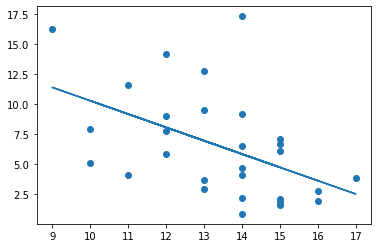

In [273]:
agg_counts = 2*both_counts + one_counts
perf_data = np.array(sampled_perf_raw["AMBP"])
plt.scatter(agg_counts[perf_data < 100], perf_data[perf_data < 100])

# regression plot
slope, intercept, r_value, p_value, _ = st.linregress(agg_counts[perf_data < 100], perf_data[perf_data < 100])
plt.plot(agg_counts, slope*agg_counts + intercept)

print("R^2", r_value**2, "P", p_value)
plt.show()

# The choice of binary interactions matters for performance of the estimator.

In [267]:
np.polyfit?

In [246]:
def categorize_interaction_two_way(is_binary_statuses):
    if is_binary_statuses[0] and is_binary_statuses[1]:
        return "both"
    elif not is_binary_statuses[0] and not is_binary_statuses[1]:
        return "neither"
    else:
        return "one"

In [230]:
def categorize_terms(terms):
    counts = defaultdict(int)
    components = defaultdict(list)
    
    for term in terms:
        if not term.free_symbols:
            continue
        
        poly_term = poly(term)
        variables = poly_term.gens
        max_deg = max(poly_term.degree_list())
        
        if len(variables) == 2:
            assert(max_deg == 1)
            category = Constants.DGPSampling.INTERACTION_TWO_WAY
        elif len(variables) == 3:
            assert(max_deg == 1)
            category = Constants.DGPSampling.INTERACTION_THREE_WAY
        elif len(variables) > 3:
            raise Exception("Unexpected degree!")
        elif max_deg == 2:
            assert(len(variables) == 1)
            category = Constants.DGPSampling.POLY_QUADRATIC
        elif max_deg == 3:
            assert(len(variables) == 1)
            category = Constants.DGPSampling.POLY_CUBIC
        elif not variables[0].is_Atom:
            assert(len(variables) == 1)
            category = STEP_CONSTANT + "/" + STEP_VARIABLE
        else:
            assert(len(variables) ==1 and max_deg == 1)
            category = Constants.DGPSampling.LINEAR
        
        counts[category] += 1
        components[category].append((variables))
        
    return counts, components

In [216]:
dgp.treatment_logit_terms

array([0, 0.8*X1, -0.25*X2, 0.6*X3, -0.4*X4, -0.8*X5, -0.5*X6, 0.7*X7, 0,
       0, 0, -0.25*X2**2, -0.4*X4**2, 0.7*X7**2, 0.4*X1*X3, -0.175*X2*X4,
       0.3*X3*X5, -0.28*X4*X6, -0.4*X5*X7, 0.4*X1*X6, -0.175*X2*X3,
       0.3*X3*X4, -0.2*X4*X5, -0.4*X5*X6], dtype=object)